In [2]:
# checking Java installation
!$JAVA_HOME/bin/java -version
!echo $JAVA_HOME
!export PATH=$JAVA_HOME/bin:$PATH
!echo $PATH
!java -version

openjdk version "21.0.6" 2025-01-21
OpenJDK Runtime Environment (build 21.0.6+7-Ubuntu-124.04.1)
OpenJDK 64-Bit Server VM (build 21.0.6+7-Ubuntu-124.04.1, mixed mode, sharing)

/home/kolim/Projects/pytetrad_plus/.venv/bin:/home/kolim/.vscode-server/cli/servers/Stable-17baf841131aa23349f217ca7c570c76ee87b957/server/bin/remote-cli:/home/kolim/bin:/home/kolim/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/kolim/.lmstudio/bin:/home/kolim/.lmstudio/bin:/home/kolim/.lmstudio/bin
openjdk version "21.0.6" 2025-01-21
OpenJDK Runtime Environment (build 21.0.6+7-Ubuntu-124.04.1)
OpenJDK 64-Bit Server VM (build 21.0.6+7-Ubuntu-124.04.1, mixed mode, sharing)


In [3]:
# Jpype1 for interacting with tetrad with python
!pip install JPype1
# pytetrad package
!pip install git+https://github.com/cmu-phil/py-tetrad
# extras to add to pytetrad to support use in jupyter notebooks and processing
!pip install pytetrad_plus


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/cmu-phil/py-tetrad to /tmp/pip-req-build-i37ldfx5
  Running command git clone --filter=blob:none --quiet https://github.com/cmu-phil/py-tetrad /tmp/pip-req-build-i37ldfx5
  Resolved https://github.com/cmu-phil/py-tetrad to commit 2bfb37cc1ea53a398a95e8bd3f368948570646df
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip install dgraph_flex



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


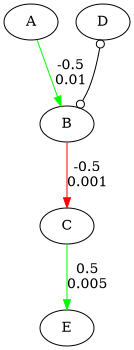

In [5]:
from dgraph_flex import DgraphFlex

obj = DgraphFlex()
# add edges to graph object
obj.add_edge('A', '-->', 'B', color='green', strength=-0.5, pvalue=0.01)
obj.add_edge('B', '-->', 'C', color='red', strength=-.5, pvalue=0.001)
obj.add_edge('C', '-->', 'E', color='green', strength=0.5, pvalue=0.005)
obj.add_edge('D', 'o-o', 'B')
# load into graphviz object and render to window
obj.show_graph()


Run an analysis on my own data. I need to be able to access the data.


In [6]:
# get line counts
!wc  pytetrad_plus/boston_data_raw.csv
!wc  pytetrad_plus/boston_data.csv

  642   642 30641 pytetrad_plus/boston_data_raw.csv


   622    622 166889 pytetrad_plus/boston_data.csv


In [7]:
# read data

from pytetrad_plus import MyTetradSearch
import pprint

ts = MyTetradSearch()

DIR='pytetrad_plus'
# read data
df_raw = ts.read_csv(f'{DIR}/boston_data_raw.csv')
df = ts.read_csv(f'{DIR}/boston_data.csv')

df_raw

,alcohol_bev,TIB,TST,PANAS_PA,PANAS_NA,worry_scale,PHQ9
0,1.0,9.00,7.333333,44.0,13.0,8.0,0.0
1,0.0,10.25,8.750000,40.0,12.0,14.0,0.0
2,1.0,8.50,7.166667,39.0,12.0,15.0,0.0
3,1.0,8.75,8.083333,39.0,12.0,12.0,0.0
4,1.0,8.25,6.666667,38.0,13.0,15.0,0.0
...,...,...,...,...,...,...,...
636,4.0,8.75,7.916667,29.0,12.0,17.0,3.0
637,4.0,8.50,7.666667,31.0,12.0,17.0,4.0
638,3.0,8.50,7.583333,33.0,13.0,17.0,3.0
639,3.0,9.00,8.166667,31.0,12.0,19.0,2.0


In [8]:
# add the lag columns
df_lag = ts.add_lag_columns(df, lag_stub='_lag')
# standardize the data
df_lag_std = ts.standardize_df_cols(df_lag)

print(f"DataFrame loaded and lag columns added, columns standardized. Number of rows: {len(df_lag)}")
df_lag

DataFrame loaded and lag columns added, columns standardized. Number of rows: 620


,alcohol_bev,TIB,TST,PANAS_PA,PANAS_NA,worry_scale,PHQ9,alcohol_bev_lag,TIB_lag,TST_lag,...,PANAS_NA_lag,worry_scale_lag,PHQ9_lag,alcohol_bev_lag_lag,TIB_lag_lag,TST_lag_lag,PANAS_PA_lag_lag,PANAS_NA_lag_lag,worry_scale_lag_lag,PHQ9_lag_lag
0,0.737309,0.627810,-0.064691,-1.235225,1.953758,-1.467482,-0.185695,-0.901155,2.742893,1.611386,...,1.953758,-1.717621,-0.185695,0.686803,1.190124,0.143559,-0.224072,2.647585,-2.698502,-0.185695
1,0.737309,0.929965,0.905669,-1.235225,1.953758,-2.217899,-0.185695,0.737309,0.627810,-0.064691,...,1.953758,-1.467482,-0.185695,-0.961524,2.673657,1.668876,-1.014917,1.602486,-1.385717,-0.185695
2,0.737309,0.325656,-0.593978,-1.430261,3.149936,-1.467482,-0.185695,0.737309,0.929965,0.905669,...,1.953758,-2.217899,-0.185695,0.686803,0.596710,-0.035890,-1.212628,1.602486,-1.166920,-0.185695
3,-0.901155,0.325656,0.199953,-1.625297,1.953758,-1.217343,-0.185695,0.737309,0.325656,-0.593978,...,3.149936,-1.467482,-0.185695,0.686803,0.893417,0.951080,-1.212628,1.602486,-1.823312,-0.185695
4,-0.901155,0.023501,0.111738,-1.820332,-0.438599,-1.217343,-0.185695,-0.901155,0.325656,0.199953,...,1.953758,-1.217343,-0.185695,0.686803,0.300003,-0.574237,-1.410339,2.647585,-1.166920,-0.185695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,-0.337178,0.871169,1.253126,-0.981533,-1.383252,-1.341641,0.000000,1.107871,-2.338400,-1.993048,...,-0.461084,-0.447214,0.000000,1.107871,-0.030443,0.366180,0.044117,-0.501636,0.429198,-0.041922
616,-0.337178,0.412659,0.789387,-0.450974,-1.383252,-1.341641,1.167748,-0.337178,0.871169,1.253126,...,-1.383252,-1.341641,0.000000,1.107871,-2.313678,-1.916104,-0.485284,-0.501636,-0.490511,-0.041922
617,-1.059703,0.412659,0.634807,0.079584,-1.075863,-1.341641,0.000000,-0.337178,0.412659,0.789387,...,-1.383252,-1.341641,1.167748,-0.337178,0.882851,1.279093,-1.014684,-1.442202,-1.410220,-0.041922
618,-1.059703,1.329678,1.716865,-0.450974,-1.383252,0.447214,-1.167748,-1.059703,0.412659,0.634807,...,-1.075863,-1.341641,0.000000,-0.337178,0.426204,0.822637,-0.485284,-1.442202,-1.410220,1.215743


In [9]:
df1 = df.copy()
df2 = df_lag_std.copy()

print(f"Dataframes are equal: {df1.equals(df2)}")

diff_mask = df.ne(df2)

# Apply styling
def highlight_diff(data, diff_mask):
    # Create a dataframe of the same shape with empty strings
    # This is necessary for applying styles based on another dataframe (the mask)
    empty_df = pd.DataFrame('', index=data.index, columns=data.columns)
    # Apply a background color to cells where diff_mask is True
    return empty_df.mask(diff_mask, 'background-color: yellow')

# Apply the styling to one of the dataframes (e.g., df1) based on the diff_mask
# You can then display both styled dataframes side-by-side for comparison
df1_styled = df1.style.apply(highlight_diff, diff_mask=diff_mask, axis=None)
df2_styled = df2.style.apply(highlight_diff, diff_mask=diff_mask, axis=None)

print("Dataframe 1 with differences highlighted:")
display(df1_styled) # Use display() in environments that support it

print("\nDataframe 2 with differences highlighted:")
display(df2_styled) # Use display() in environments that support it

Dataframes are equal: False


ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [50]:
print(len(df1))
print(len(df2))

621
640


In [ ]:

# load prior
prior_lines = ts.read_prior_file(f'{DIR}/boston_prior.txt')
# extract knowledge
knowledge = ts.extract_knowledge(prior_lines)
pprint.pprint(knowledge)

ts.load_knowledge(knowledge)

searchResult = ts.run_model_search(df, model='gfci',
                                                    knowledge=knowledge,
                                                    score={'sem_bic': {'penalty_discount': 1.0}},
                                                    test={'fisher_z': {'alpha': .05}})

edges = list(searchResult['setEdges'])
pprint.pprint(edges)

SyntaxError: f-string: expecting '}' (1796235988.py, line 2)

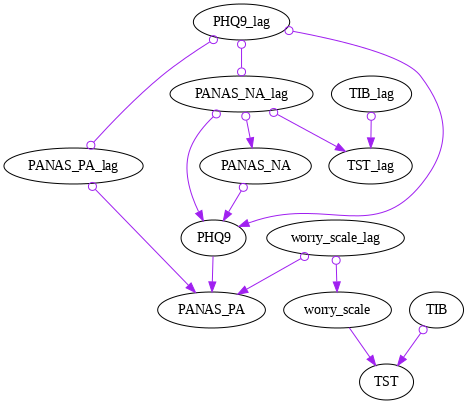

In [40]:
from dgraph_flex import DgraphFlex
# create graph output
obj = DgraphFlex()
# add edges to graph object
for edge in edges:
  source,edge_type, target = edge.split(' ')
  obj.add_edge(source,edge_type, target, color='purple')

obj.show_graph()

In [57]:
# read in the data file  df_raw means no lag
df_raw_std = ts.read_csv('data_boston/boston_data_std.csv')

# add the lag columns
df_raw_std_lag = ts.add_lag_columns(df_raw_std, lag_stub='_lag')
# standardize the data
df_raw_std_lag_std = ts.standardize_df_cols(df_raw_std_lag)

df_raw_std_lag_std

,alcohol_bev,TIB,TST,PANAS_PA,PANAS_NA,worry_scale,PHQ9,alcohol_bev_lag,TIB_lag,TST_lag,PANAS_PA_lag,PANAS_NA_lag,worry_scale_lag,PHQ9_lag
0,-1.008404,2.685616,1.632941,-1.047350,1.651034,-1.431864,-0.182722,0.777999,1.182483,0.110386,-0.256129,2.695707,-2.744949,-0.186765
1,0.780067,0.585698,-0.069185,-1.245249,1.651034,-1.210592,-0.182722,-1.009803,2.680783,1.633480,-1.047825,1.637231,-1.423266,-0.186765
2,0.780067,0.885686,0.916256,-1.245249,1.651034,-1.874407,-0.182722,0.777999,0.583163,-0.068802,-1.245749,1.637231,-1.202986,-0.186765
3,0.780067,0.285710,-0.606698,-1.443148,2.714592,-1.210592,-0.182722,0.777999,0.882823,0.916730,-1.245749,1.637231,-1.863827,-0.186765
4,-1.008404,0.285710,0.199572,-1.641047,1.651034,-0.989321,-0.182722,0.777999,0.283503,-0.606364,-1.443673,2.695707,-1.202986,-0.186765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,-0.357411,0.900562,1.284633,-1.011369,-1.403237,-1.356036,0.037163,1.228561,-2.349103,-1.953670,-0.476045,-0.465257,-0.440910,0.034017
636,-0.357411,0.436227,0.821988,-0.475641,-1.403237,-1.356036,1.198061,-0.359054,0.897682,1.285140,-1.011840,-1.402448,-1.347778,0.034017
637,-1.151515,0.436227,0.667773,0.060086,-1.089340,-1.356036,0.037163,-0.359054,0.433855,0.822453,-0.476045,-1.402448,-1.347778,1.199654
638,-1.151515,1.364896,1.747278,-0.475641,-1.403237,0.465862,-1.123735,-1.152862,0.433855,0.668224,0.059750,-1.090051,-1.347778,0.034017


In [58]:

# load prior
prior_lines = ts.read_prior_file('data_boston/boston_prior.txt')
# extract knowledge
knowledge = ts.extract_knowledge(prior_lines)
pprint.pprint(knowledge)

ts.load_knowledge(knowledge)

searchResult = ts.run_model_search(df_raw_std_lag_std, model='gfci',
                                    knowledge=knowledge,
                                                    score={'sem_bic': {'penalty_discount': 1.0}},
                                                    test={'fisher_z': {'alpha': .05}})

edges = list(searchResult['setEdges'])
pprint.pprint(edges)

{'addtemporal': {0: ['alcohol_bev_lag',
                     'TIB_lag',
                     'TST_lag',
                     'PANAS_PA_lag',
                     'PANAS_NA_lag',
                     'worry_scale_lag',
                     'PHQ9_lag'],
                 1: ['alcohol_bev',
                     'TIB',
                     'TST',
                     'PANAS_PA',
                     'PANAS_NA',
                     'worry_scale',
                     'PHQ9']}}
['PHQ9_lag o-> PHQ9',
 'TIB_lag o-> TST_lag',
 'worry_scale_lag o-> PANAS_PA',
 'PANAS_NA_lag o-o PHQ9_lag',
 'PANAS_PA_lag o-> PANAS_PA',
 'worry_scale_lag o-> worry_scale',
 'PHQ9_lag o-o PANAS_PA_lag',
 'PHQ9 --> PANAS_PA',
 'PANAS_NA_lag o-> TST_lag',
 'TIB o-o TST',
 'PANAS_NA_lag o-> PANAS_NA',
 'PANAS_NA_lag o-> PHQ9',
 'PANAS_NA o-> PHQ9']


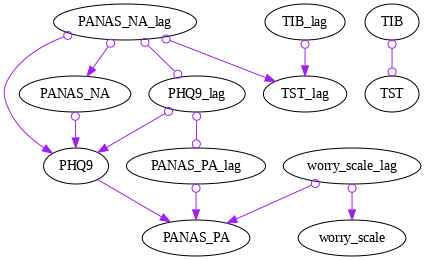

In [59]:
edges = list(searchResult['setEdges'])
obj = DgraphFlex()
# add edges to graph object
for edge in edges:
  source,edge_type, target = edge.split(' ')
  obj.add_edge(source,edge_type, target, color='purple')

obj.show_graph()

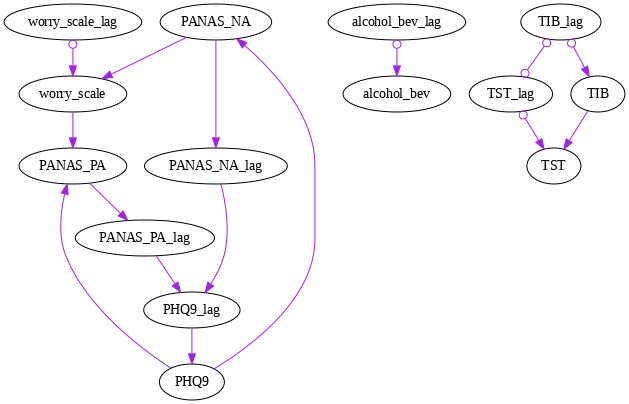

In [42]:
# run with our created lag data
searchResult = ts.run_model_search(df_lag_std, model='gfci',
                                                    knowledge=knowledge,
                                                    score={'sem_bic': {'penalty_discount': 1.0}},
                                                    test={'fisher_z': {'alpha': .05}})

edges = list(searchResult['setEdges'])
obj = DgraphFlex()
# add edges to graph object
for edge in edges:
  source,edge_type, target = edge.split(' ')
  obj.add_edge(source,edge_type, target, color='purple')

obj.show_graph()

In [46]:
import pandas as pd
import numpy as np

# Example DataFrames
data1 = {'col1': [1, 2, 3], 'col2': ['a', 'b', 'c'], 'col3': [True, False, True]}
df1 = pd.DataFrame(data1)

data2 = {'col1': [1, 5, 3], 'col2': ['a', 'x', 'c'], 'col3': [True, True, True]}
df2 = pd.DataFrame(data2)

# Ensure both dataframes have the same columns in the same order for direct comparison
# You might need to reindex or select columns if they are different
# For simplicity, assuming same columns here

diff_mask = df1.ne(df2)

# Apply styling
def highlight_diff(data, diff_mask):
    # Create a dataframe of the same shape with empty strings
    # This is necessary for applying styles based on another dataframe (the mask)
    empty_df = pd.DataFrame('', index=data.index, columns=data.columns)
    # Apply a background color to cells where diff_mask is True
    return empty_df.mask(diff_mask, 'background-color: yellow')

# Apply the styling to one of the dataframes (e.g., df1) based on the diff_mask
# You can then display both styled dataframes side-by-side for comparison
df1_styled = df1.style.apply(highlight_diff, diff_mask=diff_mask, axis=None)
df2_styled = df2.style.apply(highlight_diff, diff_mask=diff_mask, axis=None)

print("Dataframe 1 with differences highlighted:")
display(df1_styled) # Use display() in environments that support it

print("\nDataframe 2 with differences highlighted:")
display(df2_styled) # Use display() in environments that support it

Dataframe 1 with differences highlighted:


,col1,col2,col3
0,1,a,True
1,2,b,False
2,3,c,True



Dataframe 2 with differences highlighted:


,col1,col2,col3
0,1,a,True
1,5,x,True
2,3,c,True


In [47]:
print(len(df1))
print(len(df2))

3
3


In [28]:
# run the sem
